### Table of Contents

* [Linear Regression](#part1)
    * [EDA](#section_1_1)
    * [Feature Selection and Engineering](#section_1_2)
    

# Linear Regression <a class="anchor" id="part1"></a>
## EDA <a class="anchor" id="section_1_1"></a>

### Project Description:
Using Hyundai Heavy Industries ships datasets, build a model that will predict the number of crew members a ship will require.
Data description: Measurements of ship tonnage (1000s), length(100's ft), passengers (100s), cabins (100s), crew (100s), and age for 158 cruise ships.

In [2]:
#imports

from pyspark.sql import SparkSession
import pandas as pd
from pyspark.mllib.stat import Statistics
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import monotonically_increasing_id

#calculating VIF:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.linalg import DenseVector
from pyspark.ml.linalg import Vectors
from pyspark.ml.evaluation import RegressionEvaluator


from pyspark.ml.feature import PCA
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml import Pipeline

In [3]:
spark = SparkSession.builder.appName("Ship_Regression").getOrCreate()
spark.sparkContext.setLogLevel('OFF')

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/21 16:21:11 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
ship_data = spark.read.csv('/Users/test/Desktop/Data_Science/Apache Spark/Python-and-Spark-for-Big-Data-master/\
Spark_for_Machine_Learning/Linear_Regression/cruise_ship_info.csv', inferSchema=True, header=True)

In [5]:
ship_data.show()

+-----------+-----------+---+------------------+----------+------+------+-----------------+----+
|  Ship_name|Cruise_line|Age|           Tonnage|passengers|length|cabins|passenger_density|crew|
+-----------+-----------+---+------------------+----------+------+------+-----------------+----+
|    Journey|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|
|      Quest|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|
|Celebration|   Carnival| 26|            47.262|     14.86|  7.22|  7.43|             31.8| 6.7|
|   Conquest|   Carnival| 11|             110.0|     29.74|  9.53| 14.88|            36.99|19.1|
|    Destiny|   Carnival| 17|           101.353|     26.42|  8.92| 13.21|            38.36|10.0|
|    Ecstasy|   Carnival| 22|            70.367|     20.52|  8.55|  10.2|            34.29| 9.2|
|    Elation|   Carnival| 15|            70.367|     20.52|  8.55|  10.2|            34.29| 9.2|
|    Fantasy|   Carnival| 23| 

In [6]:
ship_data.printSchema()
#from what we can see all data is in integer format except ship name and cruise line. 
#Ship name does not have predictive value as it's arbitrary, we will not be using it in our model.

root
 |-- Ship_name: string (nullable = true)
 |-- Cruise_line: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tonnage: double (nullable = true)
 |-- passengers: double (nullable = true)
 |-- length: double (nullable = true)
 |-- cabins: double (nullable = true)
 |-- passenger_density: double (nullable = true)
 |-- crew: double (nullable = true)



In [7]:
#checking for Nan values - there is none which makes it much easier to work with
from pyspark.sql.functions import isnan, when, count, col
ship_data.select([count(when(isnan(c), c)).alias(c) for c in ship_data.columns]).show()

+---------+-----------+---+-------+----------+------+------+-----------------+----+
|Ship_name|Cruise_line|Age|Tonnage|passengers|length|cabins|passenger_density|crew|
+---------+-----------+---+-------+----------+------+------+-----------------+----+
|        0|          0|  0|      0|         0|     0|     0|                0|   0|
+---------+-----------+---+-------+----------+------+------+-----------------+----+



In [8]:
# checking what values we can find in "Cruis_Line" column
ship_data.select(ship_data['Cruise_Line']).distinct().show()

+-----------------+
|      Cruise_Line|
+-----------------+
|            Costa|
|              P&O|
|           Cunard|
|Regent_Seven_Seas|
|              MSC|
|         Carnival|
|          Crystal|
|           Orient|
|         Princess|
|        Silversea|
|         Seabourn|
| Holland_American|
|         Windstar|
|           Disney|
|        Norwegian|
|          Oceania|
|          Azamara|
|        Celebrity|
|             Star|
|  Royal_Caribbean|
+-----------------+



In [9]:
#stats for numeric columns:
num_cols = ship_data.select(ship_data.columns[2:])
for col in num_cols.columns:
    ship_data.describe(col).show()
#from the stats below we can see that there is a big difference in max/min values of tonnage - we may need 
#to treat them as outliers. There is also a difference in scale. We will fix this by normalizing data

+-------+------------------+
|summary|               Age|
+-------+------------------+
|  count|               158|
|   mean|15.689873417721518|
| stddev| 7.615691058751413|
|    min|                 4|
|    max|                48|
+-------+------------------+

+-------+------------------+
|summary|           Tonnage|
+-------+------------------+
|  count|               158|
|   mean| 71.28467088607599|
| stddev|37.229540025907866|
|    min|             2.329|
|    max|             220.0|
+-------+------------------+

+-------+-----------------+
|summary|       passengers|
+-------+-----------------+
|  count|              158|
|   mean|18.45740506329114|
| stddev|9.677094775143416|
|    min|             0.66|
|    max|             54.0|
+-------+-----------------+

+-------+-----------------+
|summary|           length|
+-------+-----------------+
|  count|              158|
|   mean|8.130632911392404|
| stddev|1.793473548054825|
|    min|             2.79|
|    max|            11.82|

In [10]:
num_cols = num_cols.sample(False, 0.8).toPandas()

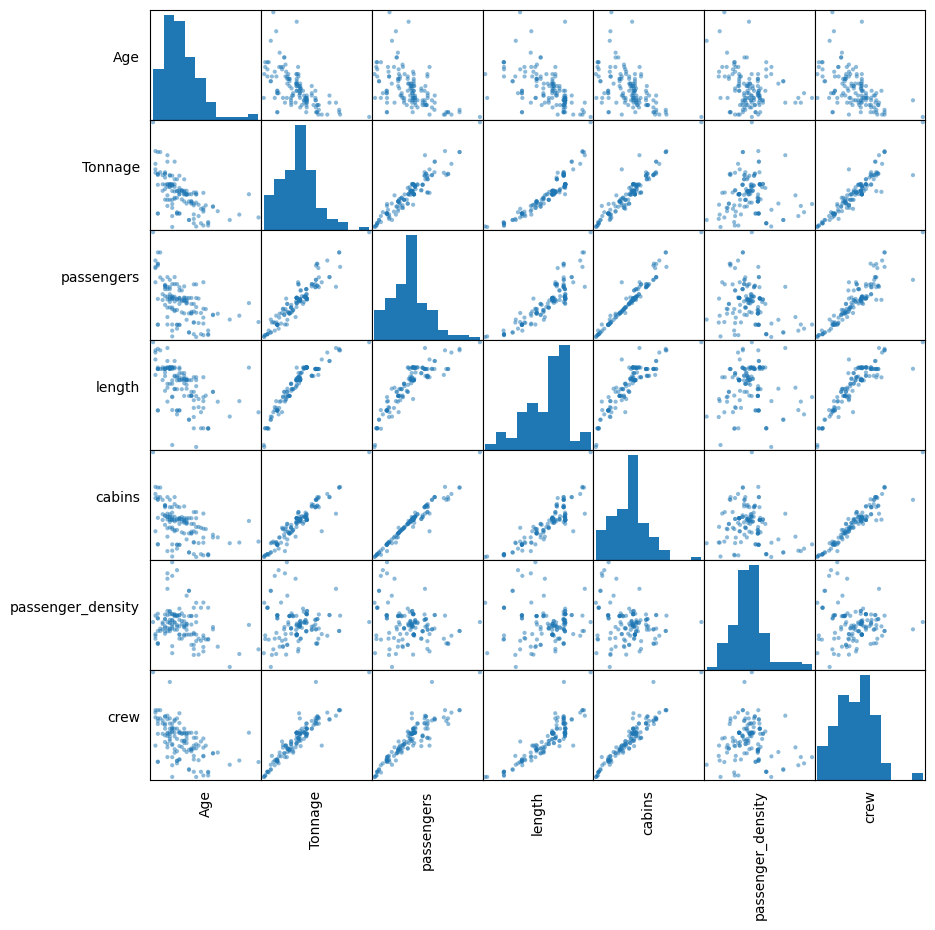

In [11]:
#investigating if relationship between dependent variable and numerical features is linear:
from pandas.plotting import scatter_matrix
axs = scatter_matrix(num_cols, figsize=(10, 10))
n = len(num_cols.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

From what we can see, all features have a linear relationship with the target, except passenger_density
we will assess if there is correlation using Spearman's coefficient, since the relatioship is non-linear

## Feature Selection and Engineering <a class="anchor" id="section_1_2"></a>

In [12]:
# Compute the correlation using Pearson's method. Enter "spearman" for Spearman's method. If a 
# method is not specified, Pearson's method will be used by default. 
corr_df = num_cols[['crew', 'passenger_density']]
corr_df = spark.createDataFrame(corr_df)

/opt/anaconda3/envs/pyspark/lib/python3.9/site-packages/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/opt/anaconda3/envs/pyspark/lib/python3.9/site-packages/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


In [13]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
vector_col = 'corr_feat'
assembler = VectorAssembler(inputCols=corr_df.columns, outputCol=vector_col)
df_vector = assembler.transform(corr_df).select(vector_col)

In [14]:
matrix = Correlation.corr(df_vector, vector_col, method = 'spearman')
corr_mtx = matrix.collect()[0][matrix.columns[0]].toArray()
corr_mtx
#from what we can see, there is not much correlation between passenger density and # 
#of crew members, we can remove this feature

array([[ 1.        , -0.04811413],
       [-0.04811413,  1.        ]])

In [17]:
#calculating vif to assess multicollinearity. We expect it to be  a problem in our model, 
#since many variables are a reflection on the size of the ship

def vif(features):
    col_names=features.columns
    vif_col_name = []
    vif_val = []
    
    for i in range(len(col_names)):
       
        train = features.rdd.map(lambda x: [Vectors.dense(x[:i]+x[i+1:]), x[i]]).toDF(['features', 'label'])
        lr = LinearRegression(featuresCol = 'features', labelCol = 'label')
        lr_model = lr.fit(train)
        predictions = lr_model.transform(train)
        evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='label')
        r_sq=evaluator.evaluate(predictions, {evaluator.metricName: "r2"})
        vif = 1/(1-r_sq)
        vif_val.append(vif)
        vif_col_name.append(col_names[i])
    return list(zip(vif_col_name, vif_val)), 

spark_num_df = spark.createDataFrame(num_cols.iloc[:,:-1])
vif_df =  vif(spark_num_df)
print(vif_df)

([('Age', 1.8856500533953475), ('Tonnage', 30.57256914439434), ('passengers', 32.33345537711288), ('length', 7.193815206255592), ('cabins', 22.85305865332618), ('passenger_density', 3.013041318060041)],)


In [18]:
'''
from the above VIF values, we can see three features with high multicollinearity: "Tonnage", 'passengers' and
cabins. To avoid removing too much information, we will try assessing multicollinearity by dropping each of 
these features

'''
collinear_feat = ['Tonnage','passengers', 'cabins']
for feat in collinear_feat:
    no_mc_df = spark_num_df.drop(feat)
    vif_df =  vif(no_mc_df)
    print(vif_df)

([('Age', 1.859898430309494), ('passengers', 23.28004688811097), ('length', 5.794186966792654), ('cabins', 20.877161421538418), ('passenger_density', 1.7629094484080416)],)


([('Age', 1.8456616380634256), ('Tonnage', 22.012211032518117), ('length', 7.187819654437745), ('cabins', 16.541429892754593), ('passenger_density', 1.9499505345016697)],)


([('Age', 1.87150145506621), ('Tonnage', 27.929235678295875), ('passengers', 23.403501186620268), ('length', 7.168785015495804), ('passenger_density', 2.9661949700171766)],)


Based on the above, removal of "passengers" feature will result in the least multicollinearity, but it's still 
quite high. In this case, we believe that feature engineering would be the best choice. 
We'll use PCA to create a new feature related to the size of the ship. PCA requires us to scale all features. 
as it's using Euclidean distance as a basis. 

In [19]:
mc_feat=spark_num_df[collinear_feat]
assembler = VectorAssembler(inputCols=mc_feat.columns, outputCol = 'features')
output = assembler.transform(mc_feat)
output.printSchema()

root
 |-- Tonnage: double (nullable = true)
 |-- passengers: double (nullable = true)
 |-- cabins: double (nullable = true)
 |-- features: vector (nullable = true)



In [20]:
#scaling the features:
scaler = StandardScaler(inputCol = 'features', outputCol = 'scaled_features')
scaler = scaler.fit(output)
scaled = scaler.transform(output)

In [21]:
#applying pca to merge three features into one:
pca = PCA(k=1, inputCol="scaled_features")
pca.setOutputCol("pca_features")
model = pca.fit(scaled)
pca_feat=model.transform(scaled)

In [22]:
pca_feat.show()

+------------------+----------+------+--------------------+--------------------+--------------------+
|           Tonnage|passengers|cabins|            features|     scaled_features|        pca_features|
+------------------+----------+------+--------------------+--------------------+--------------------+
|30.276999999999997|      6.94|  3.55|[30.2769999999999...|[0.81400115392378...|[-1.3382055155614...|
|30.276999999999997|      6.94|  3.55|[30.2769999999999...|[0.81400115392378...|[-1.3382055155614...|
|            47.262|     14.86|  7.43| [47.262,14.86,7.43]|[1.27064512787746...|[-2.5724635551412...|
|             110.0|     29.74| 14.88| [110.0,29.74,14.88]|[2.95736456490459...|[-5.387147007712638]|
|           101.353|     26.42| 13.21|[101.353,26.42,13...|[2.72488882497068...|[-4.840573031340053]|
|            70.367|     20.52|  10.2| [70.367,20.52,10.2]|[1.89182611216946...|[-3.6231184623000...|
|            70.367|     20.52|  10.2| [70.367,20.52,10.2]|[1.89182611216946...|[-

In [23]:
to_remove = pca_feat.columns[:-1]
to_remove

['Tonnage', 'passengers', 'cabins', 'features', 'scaled_features']

In [24]:
pca_feat = pca_feat.drop(*to_remove)

In [25]:
pca_feat

DataFrame[pca_features: vector]

In [26]:
#we need to convert the resulting pca vector to integer in order to perform further operations:
unlist = udf(lambda x: float(list(x)[0]), DoubleType())

pca_feat = pca_feat.withColumn("pca_features", unlist("pca_features"))
pca_feat.show(5)

+-------------------+
|       pca_features|
+-------------------+
|-1.3382055155614345|
|-1.3382055155614345|
|-2.5724635551412223|
| -5.387147007712638|
| -4.840573031340053|
+-------------------+
only showing top 5 rows



In [31]:
#in order to combine the results into one df, we have to perform a join through adding a matching column
pca_feat = pca_feat.withColumn("id",monotonically_increasing_id() )
num_df = spark_num_df.drop(*collinear_feat).withColumn( "id", monotonically_increasing_id() )
combined_data = num_df.join(pca_feat, num_df.id == pca_feat.id, how='inner')
combined_data=combined_data.drop('features','scaled_features','id')
combined_data.show()

+---+------+-----------------+-------------------+
|Age|length|passenger_density|       pca_features|
+---+------+-----------------+-------------------+
|  6|  5.94|            42.64|-1.3382055155614345|
| 19|  8.55|            34.29|-3.6231184623000985|
| 15|  8.55|            34.29|-3.6231184623000985|
| 18|  8.55|            34.29|-3.6231184623000985|
| 22|  8.55|            34.29|-3.6231184623000985|
|  6|  5.94|            42.64|-1.3382055155614345|
| 17|  8.55|            34.29|-3.6231184623000985|
| 11|  9.53|            36.99| -5.387147007712638|
|  8|  9.51|            36.99|-5.3858478041548175|
|  6|  9.51|            29.79| -5.818969579039789|
| 11|  9.63|            40.49|-3.9611314112790614|
| 26|  7.22|             31.8|-2.5724635551412223|
| 17|  8.92|            38.36| -4.840573031340053|
| 15|  8.55|            34.29|-3.6231184623000985|
| 12|  9.63|            41.67| -4.129569223343749|
| 20|  8.55|            34.29|-3.6231184623000985|
| 12|  9.63|            41.67|-

In [ ]:
vif = vif(combined_data)
print(vif)

While vif is still a bit higher than desirable after feature engineering, it has been reduced significantly, 
and we will keep all these features for our model

In [146]:
#checking how pca affected multicollinearity:
no_mc = spark_num_df.drop(*collinear_feat)
assembler = VectorAssembler(inputCols=no_mc.columns, outputCol = 'features')
#output = assembler.transform(no_mc)

pipeline = Pipeline(stages=[assembler]+[assembler_pca])
df2 = pipeline.fit(no_mc).transform(no_mc)

IllegalArgumentException: pca_features does not exist. Available: Age, length, passenger_density, features

#convert string values into integers:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
cruise_num = StringIndexer(inputCol = 'Cruise_Line', outputCol = 'cruise_num').fit(anova_df)
anova_df = cruise_num.transform(anova_df)
anova_df.show()

In [ ]:
encoder = OneHotEncoder(inputCol = 'cruise_num', outputCol = 'cruise_encoded').fit(anova_df)
encoded_df = encoder.transform(anova_df)
encoded_df.show()